<!-- COLOCAR O TREINAMENTO NUMA FUNCAO E FAZER UM GRID SEARCH -->

In [1]:
# !pip3.7 install ray==1.3.0

In [2]:
# ray.shutdown()

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print
# devo diminuir o tempo usado, no caso, o x

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
ray.init()

2021-07-21 18:06:22,343	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.15',
 'raylet_ip_address': '192.168.0.15',
 'redis_address': '192.168.0.15:6379',
 'object_store_address': '/tmp/ray/session_2021-07-21_18-06-19_764945_62197/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-07-21_18-06-19_764945_62197/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-07-21_18-06-19_764945_62197',
 'metrics_export_port': 59883,
 'node_id': '63180c5e4cdce61a28319317c77471bcbb3d9393a2b0b68079487057'}

In [5]:
import random

import ta
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensortrade.env.default as default
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import A2CAgent
import tensortrade.stochastic as sp 
from tensortrade.oms.instruments import Instrument
from tensortrade.env.default.actions import SimpleOrders, ManagedRiskOrders
from collections import OrderedDict
from tensortrade.oms.orders.criteria import Stop, StopDirection
from tensortrade.env.default.actions import ManagedRiskOrders
from tensortrade.env.default.rewards import RiskAdjustedReturns, TensorTradeRewardScheme
from scipy.signal import savgol_filter

In [6]:
from tensortrade.env.default.actions import TensorTradeActionScheme

In [7]:
import numpy as np
import pandas as pd
import os
dfs = []

for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df = pd.read_json(os.path.join(dirname, filename))
        if not df.empty and len(df) >= 51197:
            df.columns = ["unix", "open", "high", "low", "close", "volume"]
            df.drop(columns=["unix"], inplace=True)
            dfs.append(df)
            # mudei aqui para tail
        else:
            print("empty or small")
            

archive/ALICE_USDT-15m.json
empty or small
archive/BNT_USDT-15m.json
empty or small
archive/BTC_USDT-15m.json
archive/BNB_USDT-15m.json
archive/ETC_USDT-15m.json
archive/BCH_USDT-15m.json
archive/EOS_USDT-15m.json
archive/PAXG_USDT-15m.json
empty or small
archive/ICX_USDT-15m.json
archive/NANO_USDT-15m.json
archive/ZEC_USDT-15m.json
archive/OMG_USDT-15m.json
archive/LTC_USDT-15m.json
archive/DOT_USDT-15m.json
empty or small
archive/ATOM_USDT-15m.json
archive/XMR_USDT-15m.json
archive/WAVES_USDT-15m.json
archive/NEO_USDT-15m.json
archive/ETH_USDT-15m.json
archive/ENJ_USDT-15m.json
archive/ADA_USDT-15m.json
archive/XRP_USDT-15m.json
archive/LINK_USDT-15m.json


In [8]:
from gym.spaces import Space, Discrete
from tensortrade.oms.orders import (
    Broker,
    Order,
    OrderListener,
    OrderSpec,
    proportion_order,
    risk_managed_order,
    TradeSide,
    TradeType
)
from tensortrade.oms.orders.criteria import StopDirection, Stop
class BSH(TensorTradeActionScheme):
    """A simple discrete action scheme where the only options are to buy, sell,
    or hold.
    Parameters
    ----------
    cash : `Wallet`
        The wallet to hold funds in the base intrument.
    asset : `Wallet`
        The wallet to hold funds in the quote instrument.
    """

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0
        stopLoss = Stop(StopDirection('down'), 0.3)
        
        # sem criteria e com self.default stop, + durations = nada mudou 
        # sem nada = parou no 600 mas grafico foi bem parecido
        # incluindo criteria - bem diferente, apesar de negativo max 1200
        # incluindo criteria sem take - conclui quase no 1000, max 1400
        # incluindo criteria sem take - 16 neuronios - fracasso, max 1000, cabou em 500, tudo antes era 64,
        # incluindo criteria sem take - 128 neuronios - 1000, max = 2500
        # incluindo criteria sem take - 256 neuronios - 2000, max = 2600
        # incluindo criteria com take 0.05 - 256 neuronios - take 0.05 - 800-max 1300
        # incluindo criteria com 3 take 0.05 e 0.01 e 01 - 256 neuronios - bosta
        # incluindo criteria com 1 take 0.05 e 0.01 e 01 - 256 neuronios - bosta
        # incluindo criteria sem take stoploss 0.3 - 256 neuronios ruim mas parou
        # incluindo criteria sem take stoploss 0.3 - 256 neuronios 25k primeiros, ruim

        take = Stop(StopDirection('up'), 0.05)

        criteria = [stopLoss]
        criteria = self.default('criteria', criteria)
        self.criteria = criteria if isinstance(criteria, list) else [criteria]
        self.historic_awnser = []
        
        # posso mudar pra market o tipo de ordem, ai para com essa porra

        
#         acho q o correto eh usar uma criteria pra stoploss e take
#         tensortrade.org/en/latest/search.html?q=criteria&check_keywords=yes&area=default
#         https://github.com/tensortrade-org/tensortrade/blob/4a1ea95cf92a38d704056aac33b6b1d1e5416d2e/tensortrade/env/default/actions.py#L175-L211
#         stop = [0.2]
#         take = [0.05]
#         self.stop = self.default('stop', stop)
#         self.take = self.default('take', take)
        #com e sem deu msm bosta
#         durations = 200
#         durations = self.default('durations', durations)
#         self.durations = durations if isinstance(durations, list) else [durations]

# https://github.com/tensortrade-org/tensortrade/blob/4a1ea95cf92a38d704056aac33b6b1d1e5416d2e/tensortrade/oms/orders/order.py#L332
    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio') -> 'Order':
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash

            if src.balance == 0:  # We need to check, regardless of the proposed order, if we have balance in 'src'
                return []  # Otherwise just return an empty order list

            order = proportion_order(portfolio, src, tgt, 0.1)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)
        self.historic_awnser.append(action)
        return [order]

    def reset(self):
        super().reset()
        self.action = 0

        
        
class SimpleProfit(TensorTradeRewardScheme): 
    """A simple reward scheme that rewards the agent for incremental increases
    in net worth.
    Parameters
    ----------
    window_size : int
        The size of the look back window for computing the reward.
    Attributes
    ----------
    window_size : int
        The size of the look back window for computing the reward.
    """

    def __init__(self, window_size: int = 1):
        self._window_size = self.default('window_size', window_size)

    def get_reward(self, portfolio: 'Portfolio') -> float:
        """Rewards the agent for incremental increases in net worth over a
        sliding window.
        Parameters
        ----------
        portfolio : `Portfolio`
            The portfolio being used by the environment.
        Returns
        -------
        float
            The cumulative percentage change in net worth over the previous
            `window_size` time steps.
        """
        net_worths = [nw['net_worth'] for nw in portfolio.performance.values()]
        returns = [(b - a) / a for a, b in zip(net_worths[::1], net_worths[1::1])]
        returns = np.array([x + 1 for x in returns[-self._window_size:]]).cumprod() - 1
        return 0 if len(returns) < 1 else returns[-1]

In [9]:
numCoins = 1

def fetchTaFeatures(data):
    data = ta.add_all_ta_features(data, 'open', 'high', 'low', 'close', 'volume', fillna=True)
    data.columns = [name.lower() for name in data.columns]
    return data

def createEnv(config):

    coins = ["coin{}".format(x) for x in range(numCoins)]
    bitfinex_streams = []

    with NameSpace("bitfinex"):
        for coin in coins:
            coinColumns = filter(lambda name: name.startswith(coin), config["data"].columns)
            bitfinex_streams += [
                Stream.source(list(config["data"][c]), dtype="float").rename(c) for c in coinColumns
            ]


    feed = DataFeed(bitfinex_streams)
    
    streams = []
    for coin in coins:
         streams.append(Stream.source(list(data[coin+":"+"close"]), dtype="float").rename("USD-"+coin))
    streams = tuple(streams)


    bitstamp = Exchange("bitfinex", service=execute_order)(
        Stream.source(list(config["data"]["coin0:close"]), dtype="float").rename("USD-TTC0"),
#         Stream.source(list(config["data"]["coin1:close"]), dtype="float").rename("USD-TTC1"),
#         Stream.source(list(config["data"]["coin2:close"]), dtype="float").rename("USD-TTC2"),
#         Stream.source(list(config["data"]["coin3:close"]), dtype="float").rename("USD-TTC3"),
#         Stream.source(list(data["coin4:close"]), dtype="float").rename("USD-TTC4"),
#         Stream.source(list(data["coin5:close"]), dtype="float").rename("USD-TTC5"),
#         Stream.source(list(data["coin6:close"]), dtype="float").rename("USD-TTC6"),
#         Stream.source(list(data["coin7:close"]), dtype="float").rename("USD-TTC7"),
#         Stream.source(list(data["coin8:close"]), dtype="float").rename("USD-TTC8"),
#         Stream.source(list(data["coin9:close"]), dtype="float").rename("USD-TTC9"),

#         Stream.source(list(data["coin10:close"]), dtype="float").rename("USD-TTC10"),
#         Stream.source(list(data["coin11:close"]), dtype="float").rename("USD-TTC11"),
#         Stream.source(list(data["coin12:close"]), dtype="float").rename("USD-TTC12"),
#         Stream.source(list(data["coin13:close"]), dtype="float").rename("USD-TTC13"),
#         Stream.source(list(data["coin14:close"]), dtype="float").rename("USD-TTC14"),
#         Stream.source(list(data["coin15:close"]), dtype="float").rename("USD-TTC15"),
#         Stream.source(list(data["coin16:close"]), dtype="float").rename("USD-TTC16"),
#         Stream.source(list(data["coin17:close"]), dtype="float").rename("USD-TTC17"),
#         Stream.source(list(data["coin18:close"]), dtype="float").rename("USD-TTC18"),
        
    )
    instruments = []
    assets = []
    for i, coin in enumerate(coins):
        instrument = Instrument(f"TTC{i}", 8, f"TensorTrade Coin{i}")
        instruments.append(instrument)
        assets.append(Wallet(bitstamp, 0 * instrument))

    
    cash = Wallet(bitstamp, 1000 * USD)


    portfolio = Portfolio(USD, [cash] + assets)

# https://tensortradex.readthedocs.io/en/latest/api/tensortrade.actions.managed_risk_orders.html
    reward = RiskAdjustedReturns(return_algorithm = "sortino", window_size=1)
#     reward = SimpleProfit()
#  take=[0.05, 0.1, 0.04, 0.01, 0.02]
#     action_scheme = ManagedRiskOrders(stop=[0.2], trade_sizes=[4])
# criar minha classe aqui, nao vale a pena usar essa bsh sem modificar
    action_scheme = BSH(cash=cash, asset=assets[0])

    env = default.create(
      feed=feed,
      portfolio=portfolio,
      action_scheme=action_scheme,
      reward_scheme=reward,
      window_size=config["window_size"]
    )
    
    return env


In [10]:
from scipy.signal import savgol_filter

coins = ["coin{}".format(x) for x in range(numCoins)]
dfFinal = []
for i, df in enumerate(dfs[:numCoins]):
    coin = coins[i]
    for column in ["close", "open", "high", "low", "volume"]:
        df[f"diff_{column}"] = df[f"{column}"].apply(np.log).diff().dropna()
        df[f"soft_{column}"] = savgol_filter(df[column], 35, 2)
        # Usar feature selection?
    ta.add_all_ta_features(
    df,
    **{k: k for k in ['open', 'high', 'low', 'close', 'volume']})
    # testar ta normal e ta no soft
    # normal piorou
    dfFinal.append(df.add_prefix(f"{coin}:"))

data = pd.concat(dfFinal, axis=1)

data = data.reset_index(drop=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



In [11]:
# ray.shutdown()

In [12]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0.1, 1.1))
# norm_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
# import joblib

# norm_data = pd.read_csv("fake_data_norm.csv")



In [13]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG

config = DEFAULT_CONFIG.copy()
config['model']["use_lstm"] = True


# config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
# config['train_batch_size'] = 30
# config["sgd_minibatch_size"] = 10
# config['num_workers'] = 4
# config['num_sgd_iter'] = 30
# config['sgd_minibatch_size'] = 30
config['model']['lstm_use_prev_reward'] = True
config['model']['lstm_use_prev_action'] = True
cellsize = 256
config['model']['lstm_cell_size'] = cellsize

#   '': 16,

# window=15
# cell = 16
# prev action = true
# reward = true


In [14]:
config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'train_batch_size': 4000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': True,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': True,
  'lstm_use_prev_reward': True,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'attention_use_n_prev_actions': 0,
  'attention_use_n_prev_rewards': 0,
  'num_framestacks': 'auto',
  'dim

In [15]:
norm_data = data

In [16]:
# ray.shutdown()

In [17]:
# ray.init()
from ray.tune.registry import register_env

# config["env_config"]["data"]=norm_data

register_env("TradingEnv", createEnv)
config["env_config"]["data"]=norm_data
config["env_config"]["window_size"]=15
config['vf_clip_param'] = 6000000

agent = PPOTrainer(config, 'TradingEnv')

# # Tunar
# config["env_config"]["window_size"]=10
# config["model"]["max_seq_len"] = 20
# config['model']['fcnet_hiddens'] = [128, 32]
# config['train_batch_size'] = 30





2021-07-21 18:07:21,348	INFO trainer.py:669 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-07-21 18:07:21,351	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=62221) WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=62221) Instructions for updating:
(pid=62221) non-resource variables are not supported in the long term
(pid=62222) WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=62222) Instructions for updating:
(p

(pid=62221) Model: "model_1"
(pid=62221) __________________________________________________________________________________________________
(pid=62221) Layer (type)                    Output Shape         Param #     Connected to                     
(pid=62221) ==================================================================================================
(pid=62221) seq_in (InputLayer)             [(None,)]            0                                            
(pid=62221) __________________________________________________________________________________________________
(pid=62221) tf_op_layer_default_policy/Sequ [()]                 0           seq_in[0][0]                     
(pid=62221) __________________________________________________________________________________________________
(pid=62221) tf_op_layer_default_policy/Sequ [()]                 0           tf_op_layer_default_policy/Sequen
(pid=62221) _______________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [()]                 0           seq_in[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [()]                 0           tf_op_layer_default_policy/Sequen
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [(None, 1)]          0           seq_in[0][0]                     
____________________________________________________________________________________________

2021-07-21 18:07:40,916	INFO trainable.py:104 -- Trainable.setup took 19.810 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-07-21 18:07:40,920	WARNING util.py:53 -- Install gputil for GPU system monitoring.


In [18]:
for i in range(50):
    result = agent.train()
#     print(pretty_print(result))


2021-07-21 18:08:08,070	WARNING deprecation.py:34 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
2021-07-21 18:08:08,071	WARNING sgd.py:69 -- Not time-shuffling RNN data for SGD.


In [19]:
checkpoint_path = agent.save()
print(checkpoint_path)

/Users/leandronogueira/ray_results/PPO_TradingEnv_2021-07-21_18-07-20afvcyvva/checkpoint_000050/checkpoint-50


In [20]:
trained_config = config.copy()
test_agent = PPOTrainer(trained_config, 'TradingEnv')
test_agent.restore(checkpoint_path)

(pid=62223) WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=62223) Instructions for updating:
(pid=62223) non-resource variables are not supported in the long term
(pid=62224) WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=62224) Instructions for updating:
(pid=62224) non-resource variables are not supported in the long term


(pid=62223) Model: "model_1"
(pid=62223) __________________________________________________________________________________________________
(pid=62223) Layer (type)                    Output Shape         Param #     Connected to                     
(pid=62223) ==================================================================================================
(pid=62223) seq_in (InputLayer)             [(None,)]            0                                            
(pid=62223) __________________________________________________________________________________________________
(pid=62223) tf_op_layer_default_policy/Sequ [()]                 0           seq_in[0][0]                     
(pid=62223) __________________________________________________________________________________________________
(pid=62223) tf_op_layer_default_policy/Sequ [()]                 0           tf_op_layer_default_policy/Sequen
(pid=62223) _______________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [()]                 0           seq_in[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [()]                 0           tf_op_layer_default_policy/Sequen
__________________________________________________________________________________________________
tf_op_layer_default_policy/Sequ [(None, 1)]          0           seq_in[0][0]                     
____________________________________________________________________________________________

2021-07-21 19:25:57,014	INFO trainable.py:104 -- Trainable.setup took 18.814 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-07-21 19:25:57,022	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-07-21 19:25:57,239	INFO trainable.py:378 -- Restored on 192.168.0.15 from checkpoint: /Users/leandronogueira/ray_results/PPO_TradingEnv_2021-07-21_18-07-20afvcyvva/checkpoint_000050/checkpoint-50
2021-07-21 19:25:57,240	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 4673.810520887375, '_episodes_total': 10}


In [21]:
config_env = {}
config_env["data"] = norm_data
config_env["window_size"] = 15
env = createEnv(config_env)
obs = env.reset()
done = False
cumulative_reward = 0
policy = test_agent.get_policy()
state=[np.zeros(cellsize, np.float32),
       np.zeros(cellsize, np.float32)]
actions=np.zeros(2*16, np.float32).reshape(2,16)
rewards=np.zeros(16, np.float32)

action = np.zeros(env.action_space.shape, dtype=np.float32)
reward = 0
actionsA = []
episode_reward =0
i = 0 
while not done:
#     action, state, logits = policy.compute_single_action(obs, state)
#     state, reward, done, _ = env.step(action)
#     cumulative_reward += reward
    action, state, logits = test_agent.compute_action(obs, state,prev_action=action,prev_reward=reward)
    obs, reward, done, info = env.step(action)
    actionsA.append(action)
    actions[:,:-1] = actions[:,1:]
    actions[:, -1] = action
    rewards[:-1] = rewards[1:]
    rewards[-1] = reward
    episode_reward += reward


print(episode_reward)
print(actionsA)

684053400.3660156
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

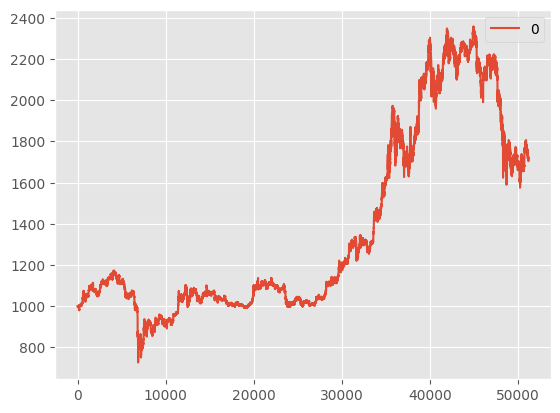

In [22]:
orDict = OrderedDict()
for k in env.action_scheme.portfolio.performance.keys():
    orDict[k] = env.action_scheme.portfolio.performance[k]["net_worth"]
pd.DataFrame().from_dict(orDict, orient='index').plot()
plt.show()

In [23]:
# ray.shutdown()

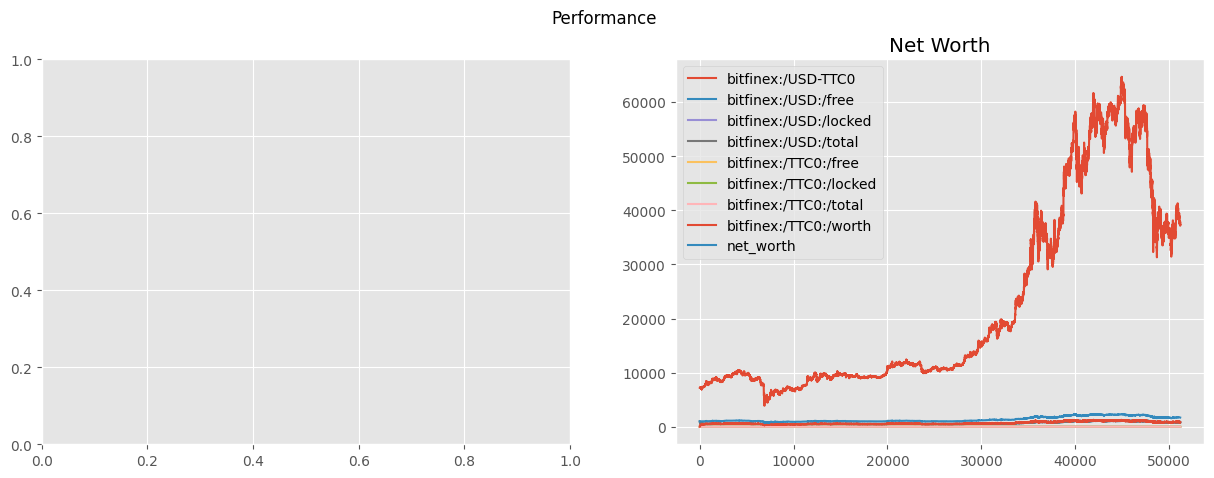

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Performance")

# axs[0].plot(np.arange(len(norm_data["close"])), norm_data["close"], label="price")
# axs[0].set_title("Trading Chart")

performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
performance_df.plot(ax=axs[1])
axs[1].set_title("Net Worth")

plt.show()



In [25]:
env.observer.history.rows

OrderedDict([(51182,
              {'bitfinex:/coin0:open': 37572.83,
               'bitfinex:/coin0:high': 37653.05,
               'bitfinex:/coin0:low': 37451.12,
               'bitfinex:/coin0:close': 37511.99,
               'bitfinex:/coin0:volume': 814.287707,
               'bitfinex:/coin0:diff_close': -0.0015505677621465708,
               'bitfinex:/coin0:soft_close': 37698.34464138086,
               'bitfinex:/coin0:diff_open': -0.0023712423149611084,
               'bitfinex:/coin0:soft_open': 37691.16382904219,
               'bitfinex:/coin0:diff_high': -0.002400110016511192,
               'bitfinex:/coin0:soft_high': 37804.59912460513,
               'bitfinex:/coin0:diff_low': -0.0013043169182722636,
               'bitfinex:/coin0:soft_low': 37564.45232927964,
               'bitfinex:/coin0:diff_volume': -0.04907061731024864,
               'bitfinex:/coin0:soft_volume': 901.6905253820826,
               'bitfinex:/coin0:volume_adi': 1738545.018486786,
          

Tune
PS: Pesado em disco e memoria

In [26]:
# ray.shutdown()

In [27]:
# from ray import tune
# import ray
# # ray.init()

# from ray.tune.registry import register_env
# register_env("TradingEnv", createEnv)
# from ray.tune.registry import register_env
# # register_env("TradingEnv", createEnv)
# config = DEFAULT_CONFIG.copy()
# config["env_config"]["data"]=norm_data
# config["env_config"]["window_size"]=tune.grid_search([10, 15, 30])
# config["env"] = "TradingEnv"

# # agent = PPOTrainer(config, 'TradingEnv')
# config['model']["use_lstm"] = True
# config['num_workers'] = 1

# config["log_level"] = "DEBUG"


# config["model"]["lstm_cell_size"] = tune.grid_search([16, 32, 62, 128, 256])
# # config["model"]["max_seq_len"] = tune.grid_search([5, 10, 16, 32, 62])
# config["model"]["lstm_use_prev_action"] = tune.grid_search([True, False])
# config["model"]["lstm_use_prev_reward"] = tune.grid_search([True, False])

In [28]:
# import os
# os.environ["TUNE_MAX_PENDING_TRIALS_PG"] = "1"



In [29]:
# # config['model']["max_seq_len"] = 32
# # config['model']["lstm_cell_size"]= 256
# from ray.tune.registry import register_env
# register_env("TradingEnv", createEnv)
# analysis = tune.run(
#     "PPO",
# #     num_samples=1,
#     stop={
# #           "episode_reward_mean": 500,
#         "training_iteration": 30

#     },
#     metric="episode_reward_mean", 
#     mode="max",
#     config=config,
#     checkpoint_at_end=True, 
# #     resume=True ,
# )

In [30]:
# config

In [31]:
# import ray.rllib.agents.ppo as ppo

# # # Get checkpoint
# checkpoints = analysis.get_trial_checkpoints_paths(
#     trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
#     metric="episode_reward_mean"
# )
# checkpoint_path = checkpoints[0][0]
# # Restore agent
# agent = ppo.PPOTrainer(
#     env="TradingEnv",
#     config=config
# )
# agent.restore(checkpoint_path)



In [32]:
# env = createEnv({
#     "window_size": 10, 
#     "data": norm_data
# })

In [33]:
# config_env = {}
# config_env["data"] = norm_data
# config_env["window_size"] = 10
# env = createEnv(config_env)
# obs = env.reset()
# done = False
# cumulative_reward = 0
# # https://github.com/ray-project/ray/issues/9220
# # ver cell_size
# policy = agent.get_policy()
# cellsize=256
# state=[np.zeros(cellsize, np.float32),
#        np.zeros(cellsize, np.float32)]
# # state = policy.get_initial_state()
# # , prev_action=0, prev_reward=0
# actions=np.zeros(2*16, np.float32).reshape(2,16)
# rewards=np.zeros(16, np.float32)
# episode_reward =0
# while not done:
#     action, state, logits = agent.compute_action(obs, state)
#     obs, reward, done, info = env.step(action)
#     actions[:,:-1] = actions[:,1:]
#     actions[:, -1] = action
#     rewards[:-1] = rewards[1:]
#     rewards[-1] = reward
#     episode_reward += reward



In [34]:
# fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# fig.suptitle("Performance")

# axs[0].plot(np.arange(len(data["coin0:close"])), data["coin0:close"], label="price")
# axs[0].set_title("Trading Chart")

# performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
# performance_df.plot(ax=axs[1])
# axs[1].set_title("Net Worth")

# plt.show()

In [35]:
# orDict = OrderedDict()
# for k in env.action_scheme.portfolio.performance.keys():
#     orDict[k] = env.action_scheme.portfolio.performance[k]["net_worth"]

In [36]:
# pd.DataFrame().from_dict(orDict, orient='index').plot()
# plt.show()

In [37]:
# config